#### Climate Analysis

In [1]:
# dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func, Column, Integer

import datetime as dt

In [2]:
# connect to DB
engine = create_engine("sqlite:///hawaii.sqlite", echo = False)
session = Session(engine)
conn = engine.connect()

In [3]:
# Base set-up
Base = automap_base()

# reflect DB tables
Base.prepare(engine, reflect = True)
Base.classes.keys()

['climate_measurements', 'station_info']

In [4]:
# assign variables
stations = Base.classes.station_info
measurements = Base.classes.climate_measurements

#### Precipitation Analysis

In [5]:
# query the measurements table
results = session.query(measurements.date, measurements.prcp).\
          filter(measurements.date.between('2016-08-23', '2017-08-23')).all()

In [6]:
precip_df = pd.DataFrame(results)
precip_df.set_index("date", inplace=True)
precip_df.head()

,prcp
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


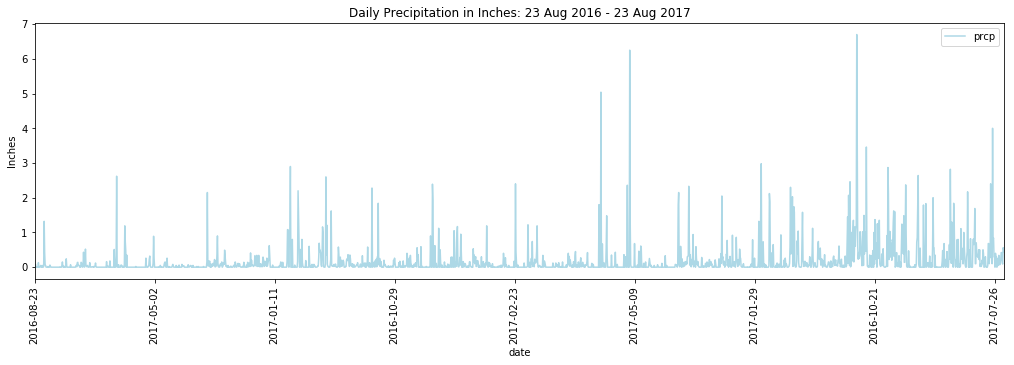

In [7]:
precip_df.plot(x_compat = True, figsize =(14, 5), rot = 90, color = "lightblue")
plt.tight_layout()
plt.title("Daily Precipitation in Inches: 23 Aug 2016 - 23 Aug 2017")
plt.ylabel("Inches")
plt.savefig("precipitation.png")
plt.show()

#### Summary

In [8]:
precip_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


#### Station Analysis

In [9]:
# total stations
print("Total Station Count: "+ str(session.query(stations.station).count()))

Total Station Count: 9


In [10]:
# station by observation count
ts = session.query(measurements.station, func.count(measurements.tobs)).\
       group_by(measurements.station).order_by(func.sum(measurements.tobs).desc()).all()
labels = ['Station', 'Observations']
top_stations = pd.DataFrame.from_records(ts, columns=labels)
top_stations

,Station,Observations
0,USC00519397,2685
1,USC00519281,2772
2,USC00513117,2696
3,USC00519523,2572
4,USC00516128,2484
5,USC00514830,1937
6,USC00511918,1932
7,USC00517948,683
8,USC00518838,342


In [11]:
# top station
top_station = session.query(stations.name).filter(stations.station == top_stations['Station'][0]).all()
print("Station with highest observation count: "+ str(top_stations['Station'][0])+" "+ str(top_station[0]))

Station with highest observation count: USC00519397 ('WAIKIKI 717.2, HI US',)


In [12]:
# station with most temp-observations/tobs with year timeframe
top_station_in_year = session.query(measurements.station, func.count(measurements.tobs)).\
                      filter(measurements.date.between('2016-08-23', '2017-08-23')).\
                      group_by(measurements.station).order_by(func.count(measurements.tobs).\
                      desc()).all()
top_station_in_year

[('USC00519397', 359),
 ('USC00519281', 352),
 ('USC00513117', 343),
 ('USC00516128', 328),
 ('USC00519523', 314),
 ('USC00514830', 265),
 ('USC00517948', 60)]

In [13]:
# tobs/day for the year timeframe
top_station_tobs = session.query(measurements.date, measurements.tobs).\
                   filter(measurements.station == top_station_in_year[0][0]).\
                   filter(measurements.date.between('2016-08-23','2017-08-23')).all()
    
top_station_tobs_df = pd.DataFrame(top_station_tobs)
top_station_tobs_df.head()

,date,tobs
0,2016-08-23,81
1,2016-08-24,79
2,2016-08-25,80
3,2016-08-26,79
4,2016-08-27,77


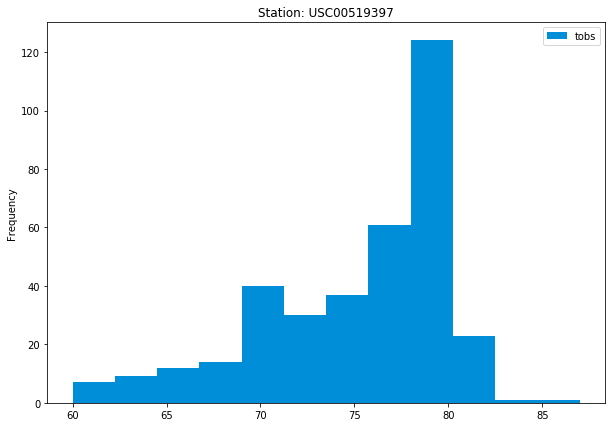

In [14]:
# plot histogram using bin=12
top_station_tobs_df.plot(kind='hist', bins=12, figsize=(10,7), color="#008ED8")
plt.title("Station: " + str(top_station_in_year[0][0]))
plt.ylabel("Frequency")
plt.savefig("station_histogram.png")
plt.show()

#### Temperature Analysis

In [15]:
# create function calc_temps
def calc_temps(start_date, end_date):
    
    data = pd.DataFrame(session.query(measurements.tobs).\
           filter(measurements.date >= (pd.to_datetime(start_date)- dt.timedelta(days = 365)).strftime('%Y-%m-%d'),\
           measurements.date < (pd.to_datetime(end_date)- dt.timedelta(days = 365)).strftime('%Y-%m-%d')).all())
    
    avg = round(data["tobs"].mean())
    low = data["tobs"].min()
    high = data["tobs"].max()
    
    print("Historical average temperature  for your vacation is: "+ str(avg) +" degrees")
    print("Historical low temperature for your vacation is: "+ str(low) +" degrees")
    print("Historical high temperature for your vacation is: "+ str(high) +" degrees")
    
    return avg, low, high

In [16]:
start_date = str(input("What is the first day of your trip: "))
end_date = str(input("What is the last day of your trip: "))
print()
print()
average, low, high = calc_temps(start_date, end_date)

What is the first day of your trip: 8-23-2016
What is the last day of your trip: 8-23-2017


Historical average temperature  for your vacation is: 74 degrees
Historical low temperature for your vacation is: 56 degrees
Historical high temperature for your vacation is: 85 degrees


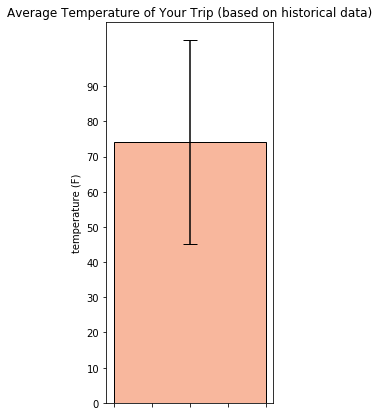

In [17]:
# plot chart
fig, ax = plt.subplots(figsize = (3,7))
ax.bar(1, average, color='#F8B79D', edgecolor='black', yerr=(high-low), capsize=7, label='test')
ax.set_xticklabels([])

plt.yticks(np.arange(0, average + 20, 10))
plt.title("Average Temperature of Your Trip (based on historical data)")
plt.ylabel("temperature (F)")
plt.savefig("avg_temp_of_your_trip.png")
plt.show()